In [18]:
#!/usr/bin/env python3
# coding: utf-8
import requests
import re
import pandas as pd
import time
import hashlib
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from tqdm import tqdm

startTime = time.time()

links = []

intro = '''
Welcome to DoDCAE. DoDCAE is a program that extracts data points 
from over 14,000 Department of Defense (DoD) contracts.The collected
data enables users to conduct trend analysis of investment, career, 
and technology trends as they pertain to the DoD. 

To extract contents please provide a date range below. Enjoy.'''

stock_quarters = pd.DataFrame(["Q1: 1JAN – 31MAR","Q2: 1APR – 30JUN","Q3: 1JUL – 30SEP","Q4: 1OCT – 31DEC"])
print(stock_quarters); print()
start_date = input("Start Format (YYYY-MM-DD):"); end_date = input("End Format (YYYY-MM-DD):")
backdate_url = f'https://www.defense.gov/News/Contracts/StartDate/{start_date}/EndDate/{end_date}/'
backdate_urlcheck = re.findall(r'https://www.defense.gov/News/Contracts/StartDate/[0-9]{4}-[0-9]{2}-[0-9]{2}/EndDate/[0-9]{4}-[0-9]{2}-[0-9]{2}/', (backdate_url))

##Input validation
if backdate_url == backdate_urlcheck[0]:
    backdate_url = backdate_urlcheck[0]

def grab_page_links(links, backdate_url, i=2):
    template = f'?Page={i}'
    url = backdate_url + template
    search = requests.get(url)
    search = BeautifulSoup(search.text, "html.parser")
    search = str(search.find_all('listing-titles-only'))
    search_links = re.findall(r'http://www.defense.gov/News/Contracts/Contract/Article/[0-9]{7,7}/', (search))

    if len(search_links) > 0:
        i = i+1
        [links.append(str) for str in search_links if str not in links]
        grab_page_links(links, backdate_url, i=i)
    else:
        search = requests.get(backdate_url)
        search = BeautifulSoup(search.text, "html.parser")
        search = str(search.find_all('listing-titles-only'))
        search_links = re.findall(r'http://www.defense.gov/News/Contracts/Contract/Article/[0-9]{7,7}/', (search))
        [links.append(str) for str in search_links if str not in links]
    return links

links = grab_page_links(links,backdate_url, i=2)

def link_hash(x):
    md5 = hashlib.md5(x.encode('utf-8')).hexdigest()
    return x, md5

link_hashes = list(map(link_hash,links))

#We request the contents from each link saving bandwidth and execution time.
def save_data(x):
    res = requests.get(x)
    soup2 = BeautifulSoup(res.text, "html.parser")
    return soup2
 
links = list(map(save_data,tqdm(links)))

def results_collection(x):
    soup2 = x
    for match in soup2.find_all('span'):
        match.unwrap()
    for match in soup2.find_all('a'):
        match.unwrap()
    for p in soup2.find_all('p'):
        if 'style' in p.attrs:
            del p.attrs['style']
    for p in soup2.find_all('p'):
        if 'class' in p.attrs:
            del p.attrs['class']
    results = soup2.find('div', attrs={'class':'body'}).find_all("p") #Article contents location
    return results

paragraphs = list(map(results_collection, links))

#Creates list of how many paragraphs exists from each link that we use to pass in our para aggregation function.
def gather_length(paragraphs):
    count = []
    x = 0
    while x != len(paragraphs):
        count.append(len(paragraphs[x]))
        x = x + 1
    return count

count = gather_length(paragraphs)

#Flattens our nested list of list into one single list.
paragraphs = [str(item) for sublist in paragraphs for item in sublist]

#Creates list of dates we encounter as we sift through each link. Used for appension to EACH paragraph.
def contract_date(x):
    soup2 = x
    contract_date = str(soup2.find("meta", property="og:title")["content"]) if str(soup2.find("meta", property="og:title")["content"]) else "no date given"
    contract_date = re.findall(r'[A-Z]{1,1}[a-z]{2,8}\s[0-9]{1,2},\s[0-9]{4,4}',(contract_date))[0]
    
    return contract_date

contract_date = list(map(contract_date, links))

#The para_aggregation appends respective contract dates to each paragraph for database granularity.
def para_aggregation(paragraphs, count, contract_date, link_hashes, new_list = [], x = 0, start = 0):
    
    if x >= len(count):
        None
    else:
        end = sum(count[0:x]) + sum(count[x:(x+1)])
        joint_string = "".join([contract_date[x], link_hashes[x][0], link_hashes[x][1]])
        contents = ["".join([item, joint_string]) for item in paragraphs[start:end]]
        new_list.extend(contents)
        x = x+1
        para_aggregation(paragraphs, count, contract_date, link_hashes, new_list = new_list, x = x, start = end)
    return new_list

paragraphs = para_aggregation(paragraphs, count, contract_date,link_hashes)

#Regex search function to build a singular table for exportation.
def regex_run(x):
    monetary, organizations, locations = [], [], []
    
    #Collect Monetary Amounts. 
    amount = re.findall(r'(\$\d+\,\d{3}\,\d{3}\,?\d{0,3})', (x))
    monetary.append(str(amount[0:1]))
    monetary_dic = {'$':'',',':'','\'':'','[':'',']':''}
    for key, value in monetary_dic.items():
        monetary = ([str.replace(key, value) for str in monetary])
        
    #Collect Organizations.
    org_name = re.findall(r'^(.+?),', (x))
    organizations.append(str(org_name))
    organizations_dic = {'<p>':'','\'':'','[':'',']':'','&amp':'','The':'','Inc':'',';':'','.':'','"':''}
    for key, value in organizations_dic.items():
        organizations = ([str.replace(key, value) for str in organizations])

    #Collect Location Data.
    loc = re.findall(r'(Alabama|Alaska|Arizona|Arkansas|Australia|California|Colorado|Connecticut|Delaware|Florida|Georgia|Hawaii|Idaho|Illinois|Indiana|Iowa|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New Hampshire|New Jersey|New Mexico|New York|North Carolina|North Dakota|Ohio|Oklahoma|Oregon|Pennsylvania|Puerto Rico|Rhode Island|South Carolina|South Dakota|Tennessee|Texas|Utah|Vermont|Virginia|Washington|West Virginia|Wisconsin|Wyoming/)', (x))
    locations.append(str(loc[0:1]))
    locations_dic = {'\'':'','[':'',']':''}
    for key, value in locations_dic.items():
        locations = ([str.replace(key, value) for str in locations])  
        
    #Month, Date, Year collection.
    contract_date = re.findall(r'[A-Z]{1,1}[a-z]{2,8}\s[0-9]{1,2},\s[0-9]{4,4}', (x))
    contract_date = contract_date[-1].replace(',', "").split()
    month, day, year = contract_date
    month_translation = {'January':[1,'Q1'],'February':[2,'Q1'],'March':[3,'Q1'],'April':[4,'Q2'],'May':[5,'Q2'],'June':[6,'Q2'],'July':[7,'Q3'],'August':[8,'Q3'],'September':[9,'Q3'],'October':[10,'Q4'],'November':[11,'Q4'],'December':[12,'Q4']}
    quarter, month = month_translation.get(month)[1], month_translation.get(month)[0]

    #Collect Source Link.
    link = re.findall(r'http://www.defense.gov/News/Contracts/Contract/Article/[0-9]{7,7}/', (x))
    link_hash = re.findall(r'[0-9a-fA-F]{32}', (x))
    
    return str(organizations[0]), str(monetary[0]), str(locations[0]), month, day, year, quarter, str(link[0]), str(link_hash[0])

data = list(map(regex_run, paragraphs))
data = list(filter(lambda tuple_spaces: '' not in tuple_spaces, data))

#Cleanse Data and Export to CSV.
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(data, columns =['Organizations', 'Monetary', 'Location', 'Month', 'Day', 'Year', 'Quarter', 'Link', 'Link MD5 Hash'])
df.Monetary, df.Month, df.Day, df.Year = df.Monetary.astype(int), df.Month.astype(int), df.Day.astype(int), df.Year.astype(int)
org_name_format=3
df['Organizations'] = df['Organizations'].apply(lambda x: ' '.join(x.split(maxsplit=org_name_format)[:org_name_format]))
df.to_csv(f'DoDCAE_{start_date}_{end_date}.csv', index=False)

executionTime = (time.time() - startTime)
print(); print('Execution time in seconds: ' + str(executionTime))


                  0
0  Q1: 1JAN – 31MAR
1  Q2: 1APR – 30JUN
2  Q3: 1JUL – 30SEP
3  Q4: 1OCT – 31DEC

Start Format (YYYY-MM-DD):2021-01-01
End Format (YYYY-MM-DD):2021-01-31


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Execution time in seconds: 24.89825701713562


,Organizations,Monetary,Location,Month,Day,Year,Quarter,Link,Link MD5 Hash
0,DoD Marine Constructors,750000000,California,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
1,TechFlow Mission Support,128970744,Idaho,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
2,MIL Corp,80864126,Maryland,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
3,Kay and Associates,69515496,Illinois,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
4,Teledyne Brown Engineering,39211704,Alabama,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
5,Raytheon Co,16095857,Washington,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
6,Heffler Contracting Group,15000000,California,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
7,Agile-Bot II LLC,14075424,Virginia,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
8,Electrical Equipment Co,10976873,Virginia,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
9,L3Harris Technologies,121634954,Indiana,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e


<AxesSubplot:xlabel='Organizations', ylabel='Monetary (in millions)'>

,Location,Monetary
57,Virginia,33000000000
63,California,4934360150
162,California,3600000000
11,New York,2625000000
170,Washington,2124531149
21,Washington,1687359008
22,Georgia,950000000
0,California,750000000
58,New Jersey,731132618
116,Indiana,625000000


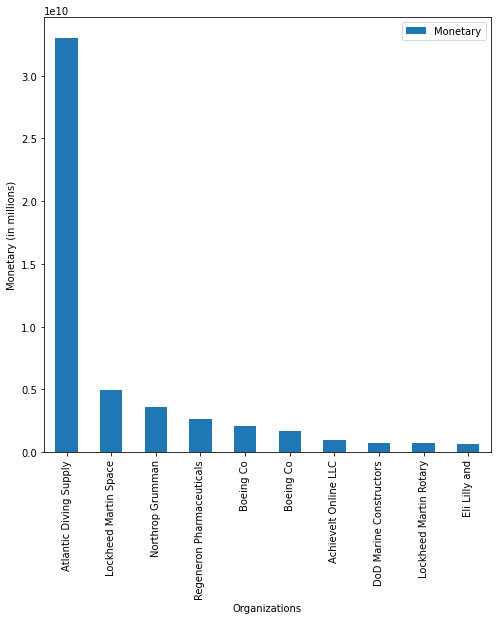

In [19]:
import matplotlib.pyplot as plt
display(df.head(10), df.sort_values('Monetary', ascending=False)[['Organizations','Monetary']].head(10).plot.bar(style='dict', ylabel='Monetary (in millions)', fontsize=10, 
       figsize=(8,8), x='Organizations', y='Monetary'), df.sort_values('Monetary', ascending=False)[['Location','Monetary']].head(10))

In [20]:
df

,Organizations,Monetary,Location,Month,Day,Year,Quarter,Link,Link MD5 Hash
0,DoD Marine Constructors,750000000,California,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
1,TechFlow Mission Support,128970744,Idaho,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
2,MIL Corp,80864126,Maryland,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
3,Kay and Associates,69515496,Illinois,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
4,Teledyne Brown Engineering,39211704,Alabama,1,14,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2473002/,f619faff8dc594f2cfc176995f2ada9e
...,...,...,...,...,...,...,...,...,...
187,Continuus Pharmaceuticals,69300000,Massachusetts,1,15,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2474326/,02cd1ba1e94be736b9bbd1274fbd0970
188,Mile Two LLC,14788874,Ohio,1,15,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2474326/,02cd1ba1e94be736b9bbd1274fbd0970
189,Nordic Industries,29554401,California,1,15,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2474326/,02cd1ba1e94be736b9bbd1274fbd0970
190,DynCorp International LLC,27700947,Texas,1,15,2021,Q1,http://www.defense.gov/News/Contracts/Contract/Article/2474326/,02cd1ba1e94be736b9bbd1274fbd0970
